# Лабораторная работа №5
# Линейные модели, SVM и деревья решений

### Цель лабораторной работы
Изучение линейных моделей, SVM и деревьев решений.

### Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
    - одну из линейных моделей;
    - SVM;
    - дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.

### Дополнительные задания
- Проведите эксперименты с важностью признаков в дереве решений.
- Визуализируйте дерево решений.

# Ход выполнения лабораторной работы

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from typing import Tuple, Dict
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree 
%matplotlib inline 
sns.set(style="ticks")

In [2]:
data = pd.read_csv('pulsar_stars.csv')

In [3]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
data.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

Таким образом, пропуски данных отсутствуют.

Разделим выборку на обучающую и тестовую:

In [5]:
# Разделим данные на целевой столбец и признаки
X = data.drop("target_class", axis=1)
Y = data["target_class"]

In [6]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((13423, 8), (4475, 8), (13423,), (4475,))

### Линейная модель

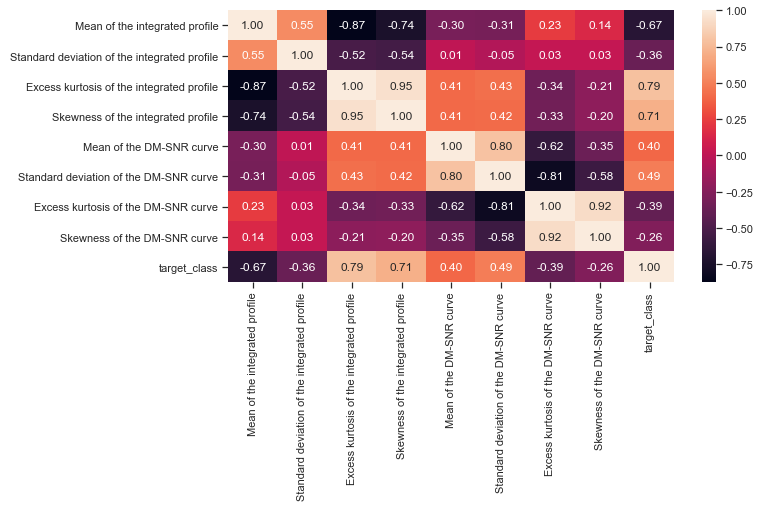

In [7]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

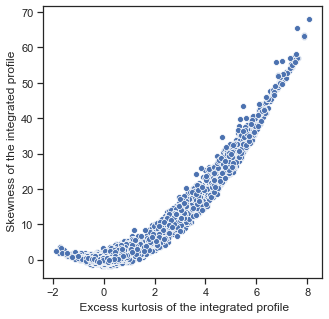

In [8]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=' Excess kurtosis of the integrated profile', y=' Skewness of the integrated profile', data=data)

In [9]:
x_array = data[' Excess kurtosis of the integrated profile'].values
y_array = data[' Skewness of the integrated profile'].values

In [10]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [11]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(-0.8493834635342365, 5.482102483932346)

In [12]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [13]:
y_array_regr = y_regr(x_array, b0, b1)

In [14]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [15]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = -0.8493834635342365 - (теоретический), 0.03448999261498756 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 0.13918310376478424 - (градиентный спуск)
MSE = 35.104804413419025


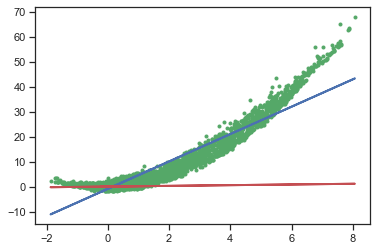

In [16]:
# Примеры использования градиентного спуска
show_gradient_descent(10, 0, 0)

b0 = -0.8493834635342365 - (теоретический), -0.1046956764421704 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 4.8016950489981 - (градиентный спуск)
MSE = 0.700140861729278


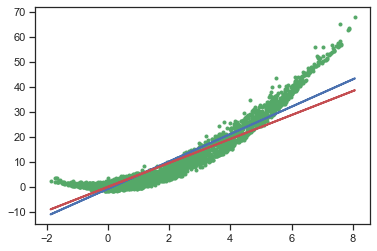

In [17]:
show_gradient_descent(1000, 0, 0)

b0 = -0.8493834635342365 - (теоретический), -0.8493787037369952 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 5.482099192076996 - (градиентный спуск)
MSE = 2.2423416471452288e-11


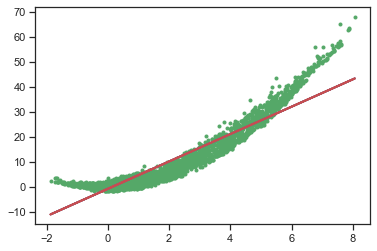

In [18]:
show_gradient_descent(10000, 0, 0)

b0 = -0.8493834635342365 - (теоретический), -1.972729515823501 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 5.023704112532512 - (градиентный спуск)
MSE = 2.039915190146421


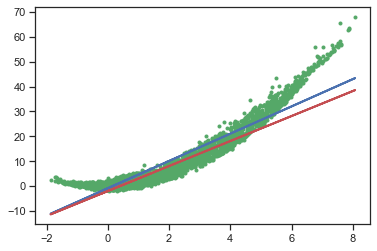

In [19]:
show_gradient_descent(10, -2, 5)

In [20]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((5.482102483932346, array([[5.48210248]])),
 (-0.8493834635342365, array([-0.84938346])))

### SVM

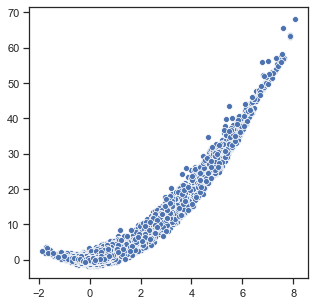

In [21]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=x_array, y=y_array)

In [22]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(x_array.reshape(-1, 1), y_array)
    y_pred = clf.predict(x_array.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x_array, y_array, 'b.')
    ax.plot(x_array, y_pred, 'ro')
    plt.show()

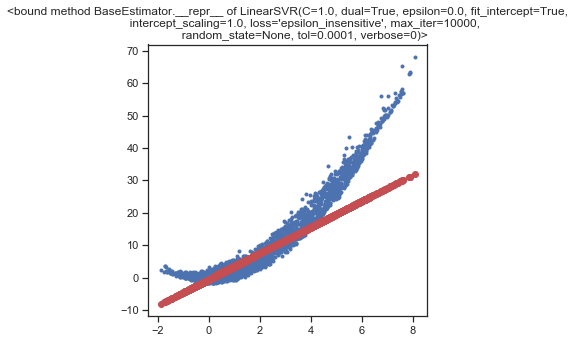

In [23]:
plot_regr(LinearSVR(C=1.0, max_iter=10000))

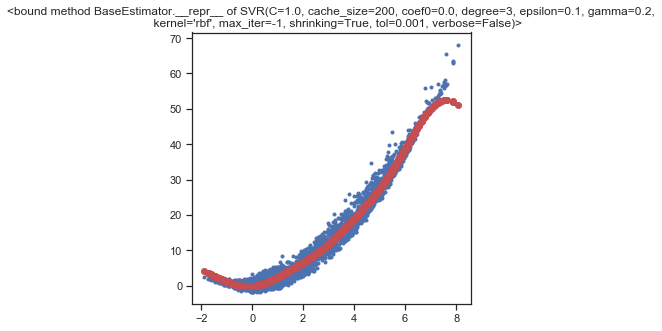

In [24]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

### Дерево решений

In [25]:
# Обучим дерево на всех признаках
tree = DecisionTreeRegressor(random_state=1)
tree.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [26]:
# Важность признаков
list(zip(X_train.columns.values, tree.feature_importances_))

[(' Mean of the integrated profile', 0.02764437664705047),
 (' Standard deviation of the integrated profile', 0.029344493324682287),
 (' Excess kurtosis of the integrated profile', 0.7986346670595349),
 (' Skewness of the integrated profile', 0.02697304742290089),
 (' Mean of the DM-SNR curve', 0.020993135609091208),
 (' Standard deviation of the DM-SNR curve', 0.05870193902245078),
 (' Excess kurtosis of the DM-SNR curve', 0.022090683667882426),
 (' Skewness of the DM-SNR curve', 0.015617657246407004)]

In [27]:
# Важность признаков в сумме дает единицу
sum(tree.feature_importances_)

1.0

In [28]:
def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

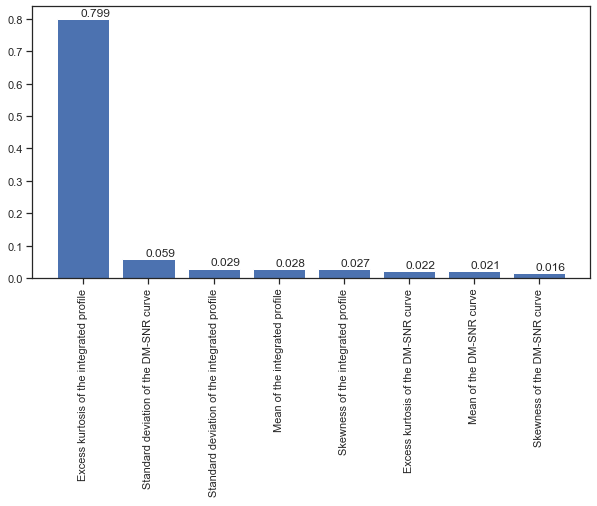

In [29]:
tree_fl, tree_fd = draw_feature_importances(tree, X_train)

In [30]:
# Список признаков, отсортированный на основе важности, и значения важности
tree_fl, tree_fd

([' Excess kurtosis of the integrated profile',
  ' Standard deviation of the DM-SNR curve',
  ' Standard deviation of the integrated profile',
  ' Mean of the integrated profile',
  ' Skewness of the integrated profile',
  ' Excess kurtosis of the DM-SNR curve',
  ' Mean of the DM-SNR curve',
  ' Skewness of the DM-SNR curve'],
 [0.7986346670595349,
  0.05870193902245078,
  0.029344493324682287,
  0.02764437664705047,
  0.02697304742290089,
  0.022090683667882426,
  0.020993135609091208,
  0.015617657246407004])

In [31]:
X_train.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
5744,79.429688,48.745943,1.594305,3.010275,19.621237,52.699148,2.758187,6.734941
12724,26.421875,28.354786,6.414866,45.383641,59.007525,58.278946,1.452548,1.756035
1010,138.476562,58.650843,-0.251328,-0.632375,2.656355,20.022599,8.482193,76.954850
15844,94.117188,41.160247,0.608247,1.171382,2.255853,17.461752,10.027291,112.565713
4163,130.039062,51.597663,-0.033977,-0.202117,17.432274,47.884699,2.799555,7.008160


In [32]:
# Пересортируем признаки на основе важности
X_train_sorted = X_train[tree_fl]
X_train_sorted.head()

,Excess kurtosis of the integrated profile,Standard deviation of the DM-SNR curve,Standard deviation of the integrated profile,Mean of the integrated profile,Skewness of the integrated profile,Excess kurtosis of the DM-SNR curve,Mean of the DM-SNR curve,Skewness of the DM-SNR curve
5744,1.594305,52.699148,48.745943,79.429688,3.010275,2.758187,19.621237,6.734941
12724,6.414866,58.278946,28.354786,26.421875,45.383641,1.452548,59.007525,1.756035
1010,-0.251328,20.022599,58.650843,138.476562,-0.632375,8.482193,2.656355,76.954850
15844,0.608247,17.461752,41.160247,94.117188,1.171382,10.027291,2.255853,112.565713
4163,-0.033977,47.884699,51.597663,130.039062,-0.202117,2.799555,17.432274,7.008160


In [33]:
Y_test_predict = tree.predict(X_test)

In [34]:
mean_absolute_error(Y_test, Y_test_predict)

0.03217877094972067

In [35]:
# Обучим дерево и предскажем результаты на пяти лучших признаках 
tree_2 = DecisionTreeRegressor(random_state=1).fit(X_train[tree_fl[0:5]], Y_train)
Y_test_predict_2 = tree_2.predict(X_test[tree_fl[0:5]])

In [36]:
mean_absolute_error(Y_test, Y_test_predict_2)

0.033072625698324025

In [37]:
# Исследуем, как изменяется ошибка при добавлении признаков в порядке значимости
X_range = list(range(1, len(X_train.columns)+1))
X_range

[1, 2, 3, 4, 5, 6, 7, 8]

In [38]:
mae_list = []
for i in X_range:
    # Обучим дерево и предскажем результаты на заданном количестве признаков 
    tree_3 = DecisionTreeRegressor(random_state=1).fit(X_train[tree_fl[0:i]], Y_train)
    Y_test_predict_3 = tree_3.predict(X_test[tree_fl[0:i]])
    temp_mae = mean_absolute_error(Y_test, Y_test_predict_3)
    mae_list.append(temp_mae)

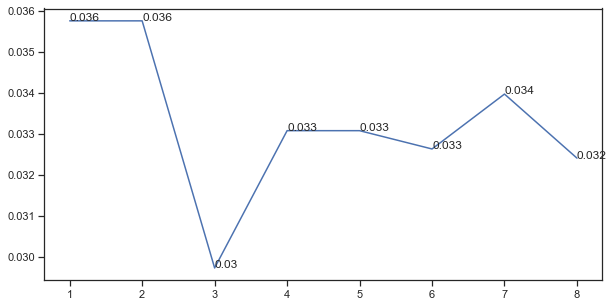

In [39]:
plt.subplots(figsize=(10,5))
plt.plot(X_range, mae_list)
for a,b in zip(X_range, mae_list):
    plt.text(a, b, str(round(b,3)))
plt.show()

### Оценка качества моделей

Дерево решений

In [40]:
print("r2_score:", r2_score(Y_test, tree.predict(X_test)))
print("mean_squared_error:", mean_squared_error(Y_test, tree.predict(X_test)))

r2_score: 0.608192211999387
mean_squared_error: 0.03217877094972067


Линейная регрессия

In [41]:
pred = reg1.predict(x_array.reshape(-1, 1))
print("r2_score:", r2_score(y_array, pred))
print("mean_squared_error", mean_squared_error(y_array, pred))

r2_score: 0.8944034470145041
mean_squared_error 4.017001458201285


Метод опорных векторов

In [42]:
svr = SVR(kernel='rbf')
svr.fit(X_train, Y_train)
print("r2_score:", r2_score(Y_test, svr.predict(X_test)))
print("mean_squared_error", mean_squared_error(Y_test, svr.predict(X_test)))

r2_score: 0.7018891842122201
mean_squared_error 0.02448353491854106


Можно сказать, что все три модели являются приемлемыми, т.к. коэффициент детерминации для всех трех моделей больше 50%. 

Если учитывать показатели обеих метрик, наилучший результат показал метод опорных векторов.